--- 1. CARGA DE DATOS ---
Dataset cargado exitosamente.

Ejemplo de datos antes de procesar:


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0



--- 2. TRADUCCIÓN DE TEXTO A NÚMEROS ---
Columnas de texto detectadas: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
 -> Columna 'sex' convertida a números.
 -> Columna 'dataset' convertida a números.
 -> Columna 'cp' convertida a números.
 -> Columna 'fbs' convertida a números.
 -> Columna 'restecg' convertida a números.
 -> Columna 'exang' convertida a números.
 -> Columna 'slope' convertida a números.
 -> Columna 'thal' convertida a números.
Variable objetivo identificada como: 'num'


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,1,0,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0
1,2,67,1,0,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,2,1
2,3,67,1,0,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,3,1
3,4,37,1,0,2,130.0,250.0,0,2,187.0,0,3.5,0,0.0,2,0
4,5,41,0,0,1,130.0,204.0,0,0,172.0,0,1.4,3,0.0,2,0



Precisión del modelo: 0.89

--- GENERANDO GRÁFICOS DE EXPLICABILIDAD ---
Formato detectado: Array 3D (Moderno)


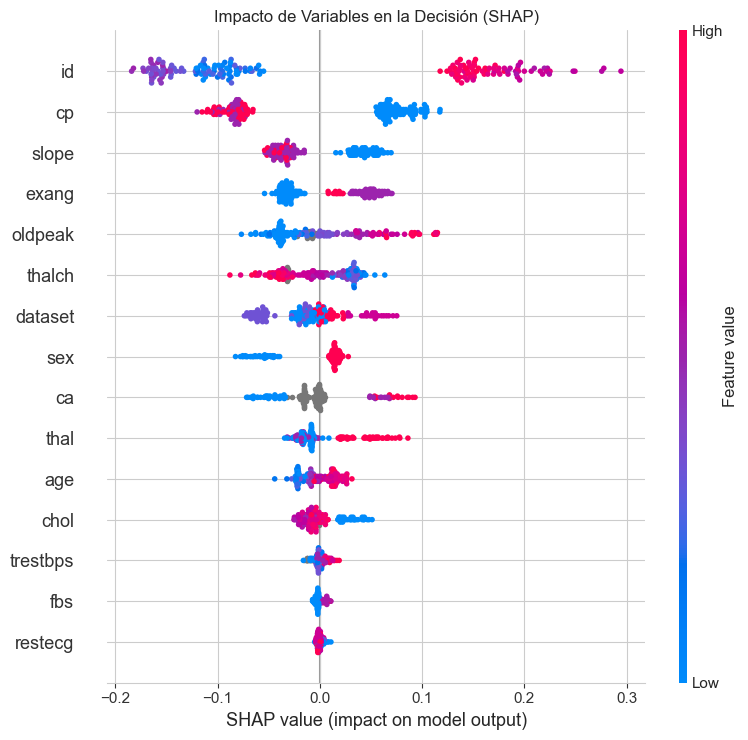


--- EXPLICACIÓN DE UN PACIENTE ESPECÍFICO ---
El modelo predice para el paciente 0: Sano (0)


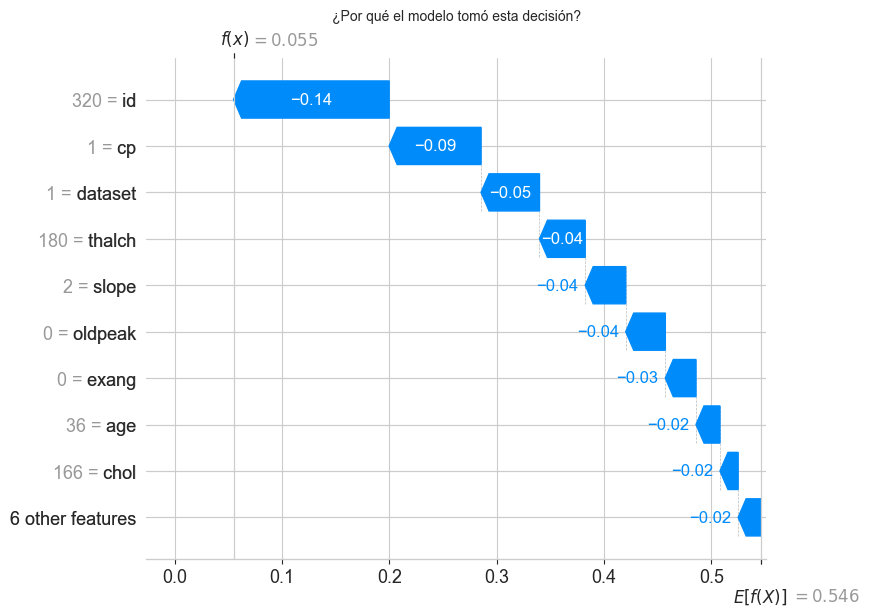


--- ANÁLISIS DE SESGOS Y ÉTICA ---
Precisión Grupo 0 (Probable Mujeres): 0.91
Precisión Grupo 1 (Probable Hombres): 0.88
Sensibilidad Grupo 0: 0.84
Sensibilidad Grupo 1: 0.91


C:\Users\javie\AppData\Local\Temp\ipykernel_18856\2194048586.py:177: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Grupo', y='Sensibilidad', data=metricas, palette='viridis')


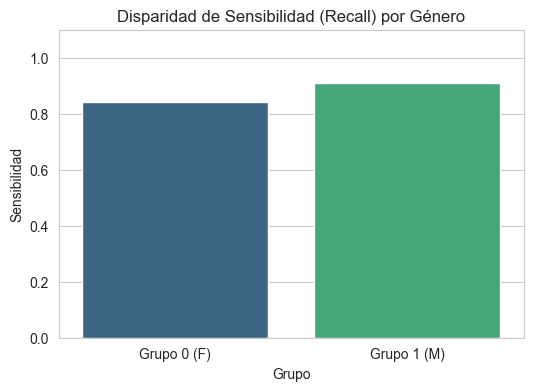


REFLEXIÓN PARA EL INFORME:
El modelo es bastante equitativo, aunque se deben vigilar falsos negativos.


In [9]:
# =============================================================================
# TALLER PRÁCTICO: XAI, ÉTICA (Script para dataset con TEXTO)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

print("--- 1. CARGA DE DATOS ---")

# URL de una versión del dataset que contiene strings (similar al que tienes)
# Si estás subiendo tu propio archivo en Colab, cambia la url por el nombre de tu archivo: "heart.csv"
url = "heart_disease_uci.csv" 

try:
    df = pd.read_csv(url)
    print("Dataset cargado exitosamente.")
except:
    print("Error cargando URL. Asegúrate de subir tu archivo csv si usas local.")

# Vista previa para confirmar que tenemos texto
print("\nEjemplo de datos antes de procesar:")
display(df.head(5))

# =============================================================================
# 2. PRE-PROCESAMIENTO
# =============================================================================
print("\n--- 2. TRADUCCIÓN DE TEXTO A NÚMEROS ---")

# Hacemos una copia para no dañar el original
df_clean = df.copy()

# Identificamos columnas que son TEXTO (Object)
cat_columns = df_clean.select_dtypes(include=['object']).columns
print(f"Columnas de texto detectadas: {list(cat_columns)}")

# Usamos LabelEncoder para convertir "Male" -> 1, "Female" -> 0, etc.
label_encoders = {}
for col in cat_columns:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le # Guardamos el diccionario para saber qué es qué
    print(f" -> Columna '{col}' convertida a números.")

# Normalización de nombres de columnas (a veces vienen con mayúsculas)
df_clean.columns = [c.lower() for c in df_clean.columns]

# Ajuste del Target (Objetivo)
# Buscamos la columna que tenga el diagnóstico. En este caso se llama 'num'
target_col = "num"
if target_col not in df_clean.columns:
    # Si no encuentra nombre conocido, asumimos la última columna
    target_col = df_clean.columns[-1]

print(f"Variable objetivo identificada como: '{target_col}'")

# Asegurar que el target es binario (0 o 1)
df_clean[target_col] = df_clean[target_col].apply(lambda x: 1 if x > 0 else 0)

display(df_clean.head())

# =============================================================================
# 3. ENTRENAMIENTO DEL MODELO
# =============================================================================
X = df_clean.drop(target_col, axis=1)
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

print(f"\nPrecisión del modelo: {accuracy_score(y_test, model.predict(X_test)):.2f}")

# =============================================================================
# 4. XAI - EXPLICABILIDAD
# =============================================================================
print("\n--- GENERANDO GRÁFICOS DE EXPLICABILIDAD ---")

# Usamos el explainer
explainer = shap.TreeExplainer(model)

# 1. OBTENCIÓN SEGURA DE SHAP VALUES
# Dependiendo de la versión de SHAP, esto devuelve una lista o un array.
raw_shap_values = explainer.shap_values(X_test)

# Lógica para detectar el formato correcto de la Clase 1 (Enfermedad)
if isinstance(raw_shap_values, list):
    # Formato antiguo: Lista de [Matriz_Clase0, Matriz_Clase1]
    shap_values_class1 = raw_shap_values[1]
    print("Formato detectado: Lista (Legacy)")
elif len(np.array(raw_shap_values).shape) == 3:
    # Formato nuevo: Array 3D (Samples, Features, Classes)
    # Seleccionamos todas las filas, todas las columnas, índice 1 de clase
    shap_values_class1 = raw_shap_values[:, :, 1]
    print("Formato detectado: Array 3D (Moderno)")
else:
    # Formato binario simplificado
    shap_values_class1 = raw_shap_values
    print("Formato detectado: Array 2D (Binario)")

# --- GRÁFICO 1: SHAP SUMMARY PLOT ---
plt.figure()
plt.title("Impacto de Variables en la Decisión (SHAP)")
# Ahora pasamos la matriz corregida 'shap_values_class1'
shap.summary_plot(shap_values_class1, X_test, show=False) 
plt.tight_layout()
plt.show()

# --- GRÁFICO 2: WATERFALL PLOT (CASO INDIVIDUAL) ---
print("\n--- EXPLICACIÓN DE UN PACIENTE ESPECÍFICO ---")

# Para waterfall, usamos la nueva API de objetos que es más estable para gráficos individuales
# Generamos el objeto 'Explanation' completo
explanation = explainer(X_test)

# Verificamos si el objeto explanation tiene dimensiones de clases
if len(explanation.shape) == 3:
    # (Filas, Columnas, Clases) -> Tomamos el paciente 0, todas las variables, clase 1
    explanation_patient = explanation[0, :, 1]
else:
    # Caso simple
    explanation_patient = explanation[0]

# Diagnóstico del paciente 0
prediccion = model.predict(X_test.iloc[[0]])[0]
print(f"El modelo predice para el paciente 0: {'Enfermedad (1)' if prediccion==1 else 'Sano (0)'}")

plt.figure()
# El gráfico Waterfall explica cómo se llega al valor final desde el promedio
shap.plots.waterfall(explanation_patient, show=False)
plt.title("¿Por qué el modelo tomó esta decisión?", fontsize=10)
plt.show()
# =============================================================================
# 5. ANÁLISIS ÉTICO (HOMBRES vs MUJERES)
# =============================================================================
print("\n--- ANÁLISIS DE SESGOS Y ÉTICA ---")
# Necesitamos saber cuál era la columna de sexo. Generalmente 'sex'.
# Si se convirtió con LabelEncoder, necesitamos saber cuál numero es cuál.
# En datasets médicos estándar: Male suele ser 1, Female suele ser 0 (o viceversa según orden alfabético).
# Asumiremos por orden alfabético de LabelEncoder: Female(0), Male(1).

if 'sex' in X_test.columns:
    sex_col = 'sex'
    # Verificamos grupos
    mask_0 = X_test[sex_col] == 0
    mask_1 = X_test[sex_col] == 1
    
    acc_0 = accuracy_score(y_test[mask_0], model.predict(X_test[mask_0]))
    acc_1 = accuracy_score(y_test[mask_1], model.predict(X_test[mask_1]))
    
    recall_0 = recall_score(y_test[mask_0], model.predict(X_test[mask_0]))
    recall_1 = recall_score(y_test[mask_1], model.predict(X_test[mask_1]))
    
    print(f"Precisión Grupo 0 (Probable Mujeres): {acc_0:.2f}")
    print(f"Precisión Grupo 1 (Probable Hombres): {acc_1:.2f}")
    print(f"Sensibilidad Grupo 0: {recall_0:.2f}")
    print(f"Sensibilidad Grupo 1: {recall_1:.2f}")
    
    # Gráfico de Sesgo
    plt.figure(figsize=(6,4))
    metricas = pd.DataFrame({
        'Grupo': ['Grupo 0 (F)', 'Grupo 1 (M)'],
        'Sensibilidad': [recall_0, recall_1]
    })
    sns.barplot(x='Grupo', y='Sensibilidad', data=metricas, palette='viridis')
    plt.title("Disparidad de Sensibilidad (Recall) por Género")
    plt.ylim(0, 1.1)
    plt.show()
    
    print("\nREFLEXIÓN PARA EL INFORME:")
    if abs(recall_0 - recall_1) > 0.1:
        print("Existe un sesgo notable. El modelo funciona mejor para un género que para el otro.")
    else:
        print("El modelo es bastante equitativo, aunque se deben vigilar falsos negativos.")
else:
    print("No se encontró columna 'sex' automáticamente para el análisis ético.")